In [2]:
import csv
import json
from collections import defaultdict
from datetime import datetime
from pathlib import Path

INPUT_CSV = Path("x.csv")
OUTPUT_JSON = Path("weeks.json")

def to_date(ts: float):
    return datetime.fromtimestamp(ts).date()

buckets = defaultdict(lambda: {"counts": defaultdict(int), "delays": []})

# --- Step 1: Load CSV and bucket rows ---
with INPUT_CSV.open(newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        try:
            ts_sent = float(row["timestamp_sent"])
            ts_completed = float(row["timestamp_completed"])
        except (ValueError, KeyError):
            continue

        sent_date = to_date(ts_sent)
        iso_year, iso_week, _ = sent_date.isocalendar()
        key = (iso_year, iso_week)

        location = row["location"].strip() if row["location"] else "Unknown"
        buckets[key]["counts"][location] += 1

        if ts_completed >= ts_sent:
            delay_days = (ts_completed - ts_sent) / 86400.0
            buckets[key]["delays"].append(delay_days)

# --- Step 2: Finalize summaries ---
weeks = []
for (year, week), data in buckets.items():
    avg_delay = (sum(data["delays"]) / len(data["delays"])) if data["delays"] else None
    weeks.append({
        "iso_year": year,
        "iso_week": week,
        "counts": dict(data["counts"]),
        "avg_delay_days": round(avg_delay) if avg_delay is not None else None
    })

# --- Step 3: Sort and save JSON ---
weeks.sort(key=lambda r: (r["iso_year"], r["iso_week"]))
OUTPUT_JSON.write_text(json.dumps({"weeks": weeks}, indent=2), encoding="utf-8")

print(f"Wrote {len(weeks)} week records → {OUTPUT_JSON}")


Wrote 63 week records → weeks.json


/var/folders/kn/0b201s912fd5np9_wflwhzy40000gn/T/ipykernel_53764/259402039.py:41: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



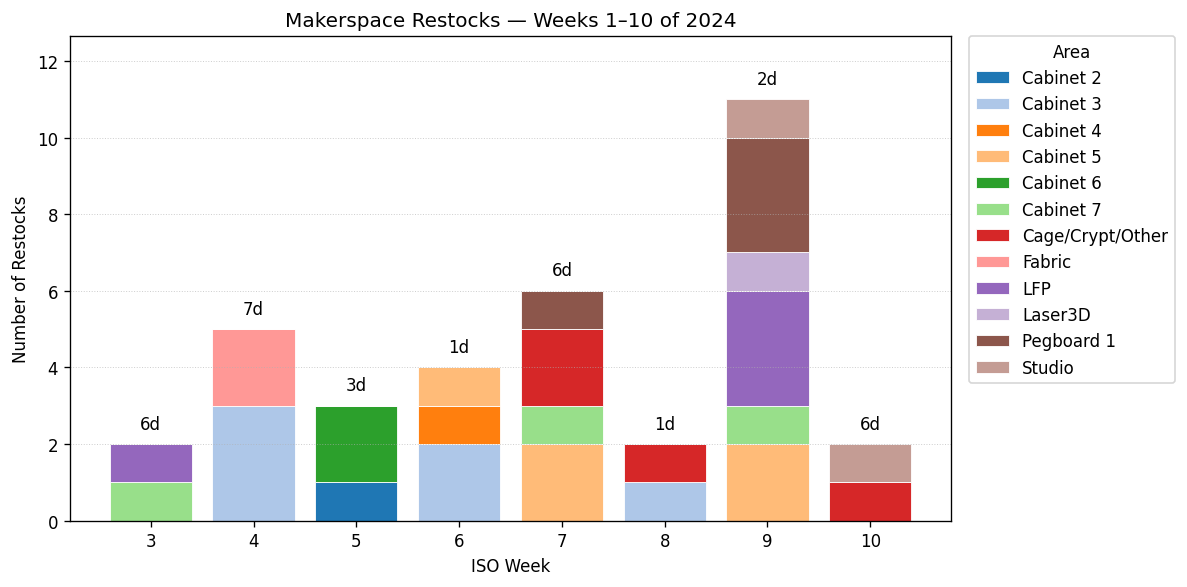

In [10]:
#  TEST - STACKED WEEKLY RESTOCKS (Matplotlib: Weeks 1–10 of 2024) 
import json
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

DATA_PATH = Path("weeks.json")
TARGET_YEAR = 2024
WEEK_RANGE = range(1, 11)  # 1..10

# Optional: set fixed colors for areas (hex or named colors).
# Leave empty {} to use Matplotlib's tab20 palette automatically.
AREA_COLOR_OVERRIDES = {
    # "Cabinet 3": "#1f77b4",
    # "Fabric": "#ff7f0e",
    # "Pegboard 1": "#2ca02c",
    # "Spraypaint": "#d62728",
    # "Cage/Crypt/Other": "#9467bd",
}

# ---- Load & filter ----
payload = json.loads(DATA_PATH.read_text(encoding="utf-8"))
weeks = [w for w in payload["weeks"]
         if w["iso_year"] == TARGET_YEAR and w["iso_week"] in WEEK_RANGE]

if not weeks:
    raise ValueError(f"No data for year={TARGET_YEAR}, weeks={list(WEEK_RANGE)}")

# Sort by week number to ensure left→right order
weeks.sort(key=lambda w: w["iso_week"])

x = [w["iso_week"] for w in weeks]
avg_delays = [w.get("avg_delay_days") for w in weeks]

# Collect all locations seen in this slice (stable alphabetical order for legend determinism)
all_locs = sorted({loc for w in weeks for loc in w["counts"].keys()})

# Build color map: use overrides first, then cycle tab20 for the rest
cmap = get_cmap("tab20")
auto_colors = [cmap(i % cmap.N) for i in range(len(all_locs))]
color_map = {}
auto_i = 0
for loc in all_locs:
    if loc in AREA_COLOR_OVERRIDES:
        color_map[loc] = AREA_COLOR_OVERRIDES[loc]
    else:
        color_map[loc] = auto_colors[auto_i]
        auto_i += 1

# Prepare stacked heights
heights_by_loc = {loc: [w["counts"].get(loc, 0) for w in weeks] for loc in all_locs}
bottom = [0] * len(weeks)

fig, ax = plt.subplots(figsize=(10, 5), dpi=120)

# Draw stacked bars
for loc in all_locs:
    vals = heights_by_loc[loc]
    ax.bar(x, vals, bottom=bottom, label=loc, color=color_map[loc], edgecolor="white", linewidth=0.5)
    # update bottom for next stack
    bottom = [b + v for b, v in zip(bottom, vals)]

# Annotate average delay above each bar
totals = bottom  # after stacking, 'bottom' equals the total per bar
for xi, total, delay in zip(x, totals, avg_delays):
    if total > 0:
        label = f"{round(delay)}d" if isinstance(delay, (int, float)) else "–"
        ax.text(xi, total + 0.3, label, ha="center", va="bottom", fontsize=10)

# Labels, legend, and styling
ax.set_title(f"Makerspace Restocks — Weeks 1–10 of {TARGET_YEAR}")
ax.set_xlabel("ISO Week")
ax.set_ylabel("Number of Restocks")
ax.set_xticks(x)
ax.set_ylim(0, max(totals) * 1.15 if totals else 1)

# Put legend outside if many areas
ax.legend(title="Area", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()
